## Text

In [267]:
# General imports
import pickle as pkl
import pandas as pd
from tqdm import tqdm
from operator import itemgetter

# Text spectific imports
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
# nltk.download(["vader_lexicon"])

# Visualization imports
import matplotlib.pyplot as plt

# Filename of all dynamic data
filename = 'temp/Dynamic_text.pkl'

from Utils.get_text import text_book

In [53]:
# Load characters wiki
character_df = pd.read_csv("1.Dataset_files/CharacterWikis_clean.csv")
character_df.Aliases = [eval(char) for char in character_df.Aliases]
character_df.Tokens = [eval(t) for t in character_df.Tokens]

# dict so we have all nodes (list of dicts of all character names (str) and their aliases (list of str)))
characters = [{'name': character_df['Name'].iloc[i], 'aliases': character_df['Aliases'].iloc[i]} for i in range(len(character_df))]

print(f" Number of characters: {len(characters)}, number of aliases: {sum([len(char['aliases']) for char in characters])}")

 Number of characters: 677, number of aliases: 1323


In [52]:
# Load the data
with open(filename, 'rb') as f:
    alltexts = pkl.load(f)

In [256]:
def get_text(start: list = [1, 1], stop: list = [7, 37], characters_to_get: list = []) -> dict:
    """
    Returns a dict of the characters and their text for the window between start and stop.
    start: list of [book, chapter]
    stop: list of [book, chapter]
    characters: list of of all characters we want to get the text from. Note that this should be the character name, not the aliases.
    """
    text_dict = {name: [] for name in characters_to_get}
    
    for char in characters_to_get:
        temp = {booknr: alltexts[char].get(booknr) for booknr in range(start[0], stop[0]+1)}
        for booknr in range(start[0], stop[0]+1):
            if start[0] == stop[0]:
                # add the text from the start to stop chapters of that one book 
                text_dict[char].append([*itemgetter(*range(start[1], stop[1]+1))(temp[booknr])])
            
            else: 
                if booknr == start[0]:
                    # add the text from the start book starting from the start chapter to the end
                    text_dict[char].append([*itemgetter(*range(start[1], len(temp[booknr])+1))(temp[booknr])])
                elif booknr == stop[0]:
                    # add the text from the stop book starting from the start to the stop chapter
                    text_dict[char].append([*itemgetter(*range(1, stop[1]+1))(temp[booknr])])
                else:
                    # add the text from the middle books completely
                    text_dict[char].append([*temp[booknr].values()])
    return text_dict

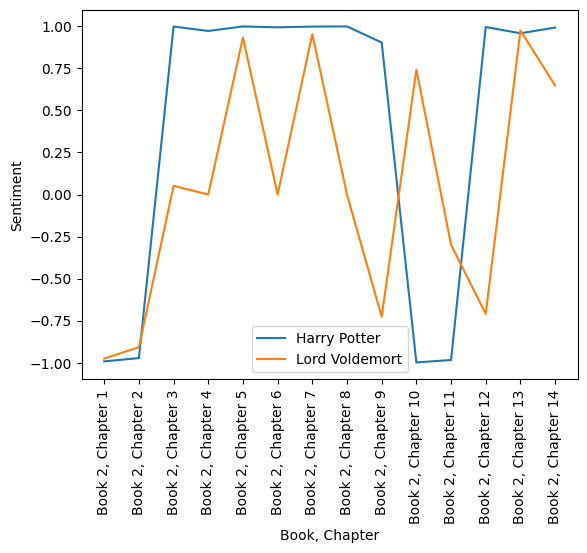

In [275]:
# Get the sentiment of text
def get_sentiment_of_text(text: list) -> float:
    """
    Returns the sentiment of the text.
    """
    text = ' '.join(text)
    sid = SentimentIntensityAnalyzer()
    return sid.polarity_scores(text)['compound']

def get_sentiment(text_dict: dict) -> dict:
    """
    Returns a dict of the characters and their sentiment for the window between start and stop.
    """
    sentiment_dict = {char: [] for char in text_dict.keys()}
    for char, char_text in text_dict.items():
        for book in char_text:
            sentiment_dict[char].append([get_sentiment_of_text(chapter) for chapter in book])

        sentiment_dict[char] = [item for sublist in sentiment_dict[char] for item in sublist]
    return sentiment_dict

def plot_sentiment(start: list = [1, 1], stop: list = [7, 37], characters_to_get: list = []):
    """
    Plots the sentiment of the characters in the window between start and stop.
    """
    text_dict = get_text(start, stop, characters_to_get)
    sentiment_dict = get_sentiment(text_dict)
    for char, sentiment in sentiment_dict.items():
        plt.plot(sentiment, label=char)
    
    chapters = [17, 18, 22, 38, 38, 32, 37]

    # Create xlabel for the plot in the form of "Book x, Chapter x"
    xlabel = []
    for i in range(len(sentiment_dict[characters_to_get[0]])):
        book = i // chapters[start[0]-1] + start[0]
        chapter = i % chapters[start[0]-1] + start[1]
        xlabel.append(f"Book {book}, Chapter {chapter}")

    plt.xticks(range(len(sentiment_dict[characters_to_get[0]])), xlabel, rotation=90)
    plt.ylabel("Sentiment")
    plt.xlabel("Book, Chapter")
    
    plt.legend()
    plt.show()

plot_sentiment(start=[2,1], stop=[2, 14], characters_to_get=['Harry Potter', 'Lord Voldemort'])